In [1]:
pip install gymnasium numpy matplotlib tensorflow

  Using cached gymnasium-1.0.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached gymnasium-1.0.0-py3-none-any.whl (958 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 4.7 MB/s eta 0:00:00a 0:00:02
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 4.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class ComplexMazeEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), start=(3, 3), goal=(8, 1), obstacles=None):
        super(ComplexMazeEnv, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.state = start

        # Define action space (Up, Down, Left, Right)
        self.action_space = spaces.Discrete(4)

        # Define state space (2D coordinates)
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(2,), dtype=np.int32)

        # Define obstacles
        self.obstacles = obstacles if obstacles else [(3,3), (3,4), (3,5), (5,6), (6,6), (7,6)]

    def step(self, action):
        x, y = self.state

        if action == 0:  # Up
            x = max(x - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size[0] - 1)
        elif action == 2:  # Left
            y = max(y - 1, 0)
        elif action == 3:  # Right
            y = min(y + 1, self.grid_size[1] - 1)

        if (x, y) in self.obstacles:
            x, y = self.state  # Stay in place if obstacle

        self.state = (x, y)

        # Reward system
        reward = 10 if self.state == self.goal else -0.1
        done = self.state == self.goal

        return np.array(self.state, dtype=np.int32), reward, done, {}

    def reset(self):
        self.state = self.start
        return np.array(self.state, dtype=np.int32)

    def render(self):
        grid = np.zeros(self.grid_size)
        grid[self.goal] = 2
        for ob in self.obstacles:
            grid[ob] = -1
        grid[self.state] = 1
        print(grid)


In [48]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time

class LargeMazeEnv(gym.Env):
    def __init__(self, grid_size=(20, 20), start=(11, 7), goal=(1, 1)):  # Updated start and goal
        super(LargeMazeEnv, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.state = start

        # Define action space (Up, Down, Left, Right)
        self.action_space = spaces.Discrete(4)

        # Define state space (2D coordinates)
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(2,), dtype=np.int32)

        # Generate a solvable maze with obstacles
        self.maze = self.generate_solvable_maze()
        self.obstacles = [(i, j) for i in range(grid_size[0]) for j in range(grid_size[1]) if self.maze[i, j] == 1]

    def generate_solvable_maze(self):
        """Generates a 20x20 maze with dead ends but ensures at least one optimal path."""
        maze = np.ones(self.grid_size)  # Start with walls (1 = wall, 0 = open path)

        def carve_path(x, y):
            """Recursive backtracking algorithm to carve out a solvable maze."""
            maze[x, y] = 0  # Mark as open path
            
            directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
            random.shuffle(directions)  # Randomize path carving

            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 1 <= nx < self.grid_size[0] - 1 and 1 <= ny < self.grid_size[1] - 1 and maze[nx, ny] == 1:
                    maze[nx - dx // 2, ny - dy // 2] = 0  # Carve through wall
                    carve_path(nx, ny)  # Recursive call

        # Start maze carving from a position near the start
        carve_path(1, 1)

        # Ensure the start and goal are open
        maze[self.start] = 0
        maze[self.goal] = 0

        return maze

    def step(self, action):
        x, y = self.state

        if action == 0:  # Up
            x = max(x - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size[0] - 1)
        elif action == 2:  # Left
            y = max(y - 1, 0)
        elif action == 3:  # Right
            y = min(y + 1, self.grid_size[1] - 1)

        if (x, y) in self.obstacles:
            x, y = self.state  # Stay in place if hitting an obstacle

        self.state = (x, y)

        # Reward system: Encourage reaching the goal efficiently
        reward = 10 if self.state == self.goal else -0.1
        done = self.state == self.goal

        return np.array(self.state, dtype=np.int32), reward, done, {}

    def reset(self):
        self.state = self.start
        return np.array(self.state, dtype=np.int32), {}  # Return state and empty info dict

    def render(self):
        """Visualize the maze."""
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap="gray_r", origin="upper")
        plt.scatter(self.start[1], self.start[0], color='green', label="Start")  # Start point
        plt.scatter(self.goal[1], self.goal[0], color='red', label="Goal")  # Goal point
        plt.legend()
        plt.title("20x20 Solvable Maze")
        plt.show()

In [49]:
class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.85, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

        self.memory = []
        self.rewards_per_episode = []  # Store rewards to track learning

    def build_model(self):
        """Create a Deep Q-Network model."""
        model = keras.Sequential([
            keras.layers.Dense(64, activation="relu", input_shape=(2,)),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(self.env.action_space.n, activation="linear")
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.alpha), loss="mse")
        return model

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def train_agent(self, episodes=300, batch_size=32):
        for episode in range(episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            step_count = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.memory.append((state, action, reward, next_state, done))
                if len(self.memory) > 2000:
                    self.memory.pop(0)
                state = next_state
                total_reward += reward
                step_count += 1

                # Print agent progress every 100000 steps
                if step_count % 100000 == 0:
                    print(f"Episode {episode} | Step {step_count} | Reward: {total_reward} | State: {state}")

            self.rewards_per_episode.append(total_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            print(f"✔️ Episode {episode} Complete | Total Reward: {total_reward} | Steps Taken: {step_count}")

    def plot_training_progress(self):
        """Plot total rewards over episodes to check learning progress."""
        plt.figure(figsize=(8, 4))
        plt.plot(self.rewards_per_episode, label="Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("DQN Training Progress")
        plt.legend()
        plt.show()


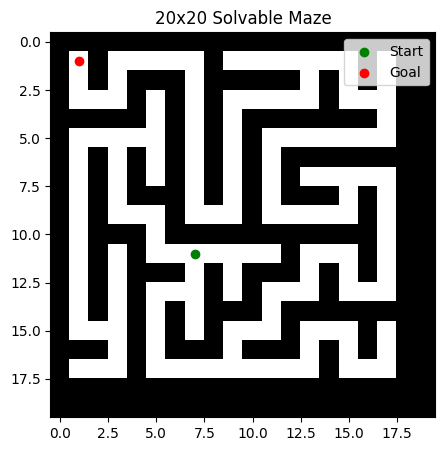

In [50]:
def visualize_trained_agent(env, agent):
    state, _ = env.reset()
    done = False
    path = [state]

    while not done:
        action = agent.choose_action(state)
        state, _, done, _ = env.step(action)
        path.append(state)

    grid = np.zeros(env.grid_size)
    for step in path:
        grid[tuple(step)] = 0.5  
    grid[env.start] = 1.0  
    grid[env.goal] = 2.0  
    for ob in env.obstacles:
        grid[ob] = -1  

    plt.figure(figsize=(5,5))
    plt.imshow(grid, cmap="gray", origin="upper")
    plt.title("DQN Agent Learned Path")
    plt.show()

# Initialize environment and train the agent

env = LargeMazeEnv()
env.render()
agent = DQNAgent(env)



In [ ]:
agent.train_agent(episodes=50)

Episode 0 | Step 10000 | Reward: -1000.0000000001588 | State: [6 3]
Episode 0 | Step 20000 | Reward: -1999.9999999992765 | State: [ 7 15]
Episode 0 | Step 30000 | Reward: -2999.999999998367 | State: [13  1]
Episode 0 | Step 40000 | Reward: -3999.9999999974575 | State: [14  7]
Episode 0 | Step 50000 | Reward: -5000.0000000006585 | State: [16 17]
Episode 0 | Step 60000 | Reward: -6000.000000004296 | State: [17  6]
Episode 0 | Step 70000 | Reward: -7000.000000007934 | State: [16 13]
✔️ Episode 0 Complete | Total Reward: -7734.200000010642 | Steps Taken: 77443
✔️ Episode 1 Complete | Total Reward: -208.39999999999188 | Steps Taken: 2185
Episode 2 | Step 10000 | Reward: -1000.0000000001588 | State: [11 14]
✔️ Episode 2 Complete | Total Reward: -1546.5999999996798 | Steps Taken: 15567
Episode 3 | Step 10000 | Reward: -1000.0000000001588 | State: [11 17]
Episode 3 | Step 20000 | Reward: -1999.9999999992765 | State: [16  5]
Episode 3 | Step 30000 | Reward: -2999.999999998367 | State: [11  8]
E

In [ ]:
agent.plot_training_progress()
visualize_trained_agent(env, agent)